<a href="https://colab.research.google.com/github/GaganKumar2375/Optical-Character-Recognition/blob/main/ClassificationReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using GPU: []
Mounted at /content/drive

✅ Dataset loaded successfully!
📌 Total samples: 50000
📌 Number of classes: 94
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.2181 - loss: 3.3815 - val_accuracy: 0.7781 - val_loss: 0.8761 - learning_rate: 0.0010
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.6960 - loss: 1.0987 - val_accuracy: 0.8345 - val_loss: 0.6188 - learning_rate: 0.0010
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.7709 - loss: 0.8115 - val_accuracy: 0.8496 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.7994 - loss: 0.6791 - val_accuracy: 0.8601 - val_loss: 0.4809 - learning_rate: 0.0010
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.8155 - loss: 0.6132 - val_accuracy: 0.8616 - val_loss: 0.4483 - learning_rate: 0.0010
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.8314 - loss: 0.5539 - val_accuracy: 0

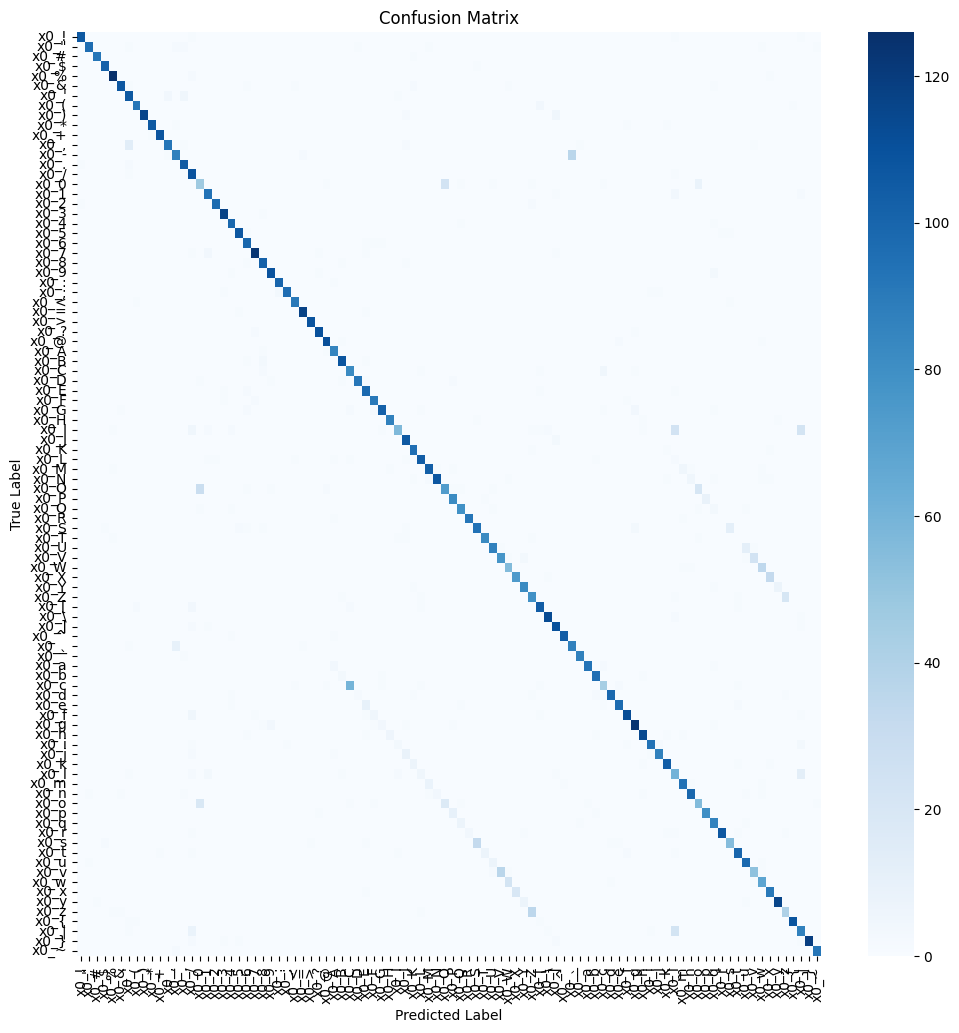

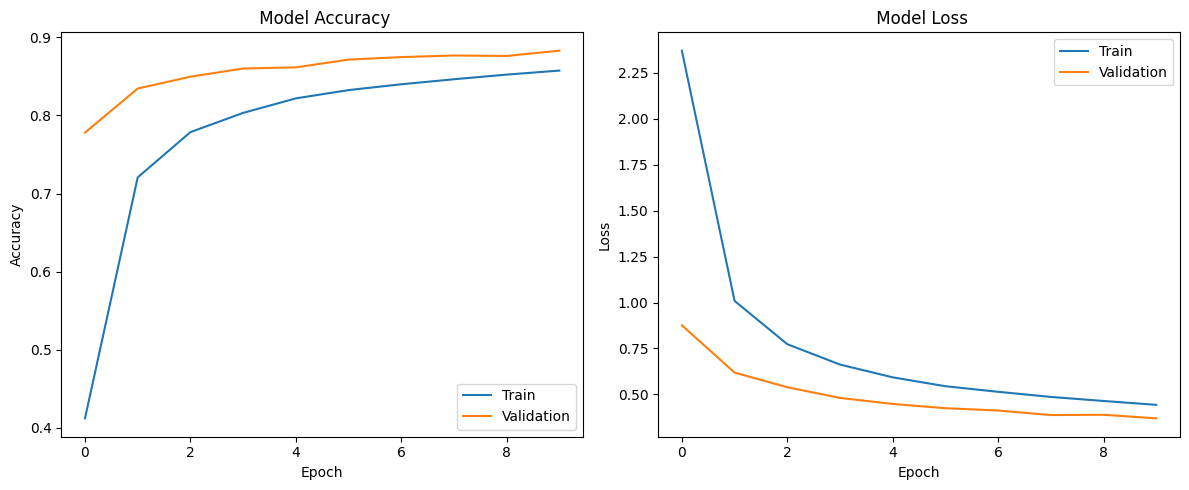

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Use GPU for acceleration
print("Using GPU:", tf.config.list_physical_devices('GPU'))

# ✅ Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# ✅ Load dataset
dataset_path = '/content/drive/MyDrive/94_character_TMNIST.csv'

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

data_frame = pd.read_csv(dataset_path)

# ✅ Reduce dataset size for faster training (comment out to use full data)
data_frame = data_frame.sample(n=50000, random_state=42)

print("\n✅ Dataset loaded successfully!")
print(f"📌 Total samples: {len(data_frame)}")
print(f"📌 Number of classes: {len(data_frame['labels'].unique())}")

# ✅ Preprocess data
X = data_frame.drop(columns=['names', 'labels']).values.reshape(-1, 28, 28, 1).astype('float32') / 255
y = data_frame['labels'].values

# ✅ One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# ✅ Build optimized FAST CNN model
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(encoder.categories_[0].size, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Callbacks for early stopping & fast convergence
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=2)
]

# ✅ Train FAST (fewer epochs & larger batch size)
history = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=10,  # Reduced from 30 to 10
                   batch_size=256,  # Increased batch size
                   callbacks=callbacks,
                   verbose=1)

# ✅ Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'\n✅ Test Accuracy: {test_acc:.4f}')

# ✅ Predictions and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print('\n📊 Classification Report:')
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=encoder.get_feature_names_out()))

# ✅ Save model
model.save('/content/drive/MyDrive/tmnist_cnn_model_fast.keras')
print('\n✅ Model saved successfully!')

# ✅ Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=encoder.get_feature_names_out(),
            yticklabels=encoder.get_feature_names_out())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ✅ Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title(' Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title(' Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()
